# Classify and clustering virus species using Genomic data

In this example, we'll use a genomic dataset that includes 120 samples of 4 types of virus: Ebola, measles, SARS-COVID-2, and MERS.

For more data: https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/

1. Classification
2. High dimensional data visualization
3. Clustering


In [107]:
import numpy as np
np.set_printoptions(threshold=np.inf)

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import glob
from functools import partial
from pathlib import Path

In [3]:
from Bio import SeqIO

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# Naive sentencing for classification


In [60]:
def Kmers_funct(seq, size=4):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]


def nucleotide2protein(dnasequence,reduce_protein=True, return_str=True):
    #DNA -> RNA -> amino acids -> proteins
    mRNA = dnasequence.transcribe()
    aacid = mRNA.translate(table=1, cds=False)
    proteins = aacid.split('*')
    if reduce_protein:
        proteins = [p for p in proteins if len(p) >=20]
    if return_str:
        proteins = [str(p) for p in proteins]
    return proteins

def parse_data(sname, transform2protein=True, **kwargs):
    samples = SeqIO.parse(sname, 'fasta')
    sample_seqs = [s.seq for s in samples]
    num = len(sample_seqs)
    if transform2protein:
        sample_proteins = [nucleotide2protein(s, **kwargs) for s in sample_seqs]
        return sample_proteins
    else:
        return sample_seqs

def sentencize_kmer(seq_list, word_size=6):
    seq = ''.join(seq_list)
    # apply Kmer-counting to seq-list
    kmers = Kmers_funct(seq, size=word_size) #k-mer words of length 6
    return ' '.join(kmers)

def chunks(lst, size=6):
    return [lst[i:i+size] for i in range(0, len(lst), size)]

def sentencize_chunk(seq_list, word_size=6):
    from itertools import chain
    word_list = [chunks(seq, size=word_size) for seq in seq_list]
#     print(word_list)
    word_list = list(chain(*word_list))
    return ' '.join(word_list)


In [56]:
sname = 'data/virus/covid.fasta'
xs = parse_data(sname, reduce_protein=True, return_str=True)

/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [57]:
xs[0]

['NLCGCHSAACLVHSRSIINN',
 'LVYLLQAAYGFVRVAADHQHI',
 'VSSGCDRKVRWRALSLVSTRKHTSNSVCLFYRFATCSYVALETPWRRSYQRHVNILKMALVA',
 'KLKKAFCLNLNSPMCSSNVRMLELHLMVMLWLSW',
 'QNSKAFSTVVVVRHLVSLSLMWAKYQWLTARFFFVRTVIKELVAIVTAPI',
 'ATSLALILMKIFKKTGTLNIAVVLPVNSCVSLTEGHTLAMSITTSVALMATLLSALKTF',
 'HVLVKLHALCPNNWTLLTLRGVYTAAVNMSMKLLGTRNVLKRAMNCRHLLKLNWQRNLTPSMGNVQILYFP',
 'SRLFNQGLKRKSLMALWVEFDLSIQLRHQMNATKCAFQLS',
 'SVIIVVKLHGRRAILLKPLANFVALRI',
 'LKKVPLLVVTYPKMLLLKFIVQHVTIQK',
 'KPFFVRVVALLPLEAVCSLMLVAITSVPIGFHVLALT',
 'VVTIQVLLEKVPKVLMTTFLKYSKKRKSTSILLVTLNLMKRSPLFWHLFLLPQVLLWKL',
 'KVWIIKHSNKLLNPVVILKLQKEKLKKVPGILVNRNQY',
 'VLFMHLHQRLLVLYDQFSPALLKLLKILCVFYRRPL',
 'LTSLALFMKNSNPSLIGLKRSLRKV',
 'SFLETVGKLLNLSQPVLVKLSVDKLSPVQRKLRRVFRHSLSL',
 'INFWLCVLTLSLLVELNLKP',
 'VKHLSRTQRDCTESVLNPEKKLAYSCL',
 'NNLLVKLLKLHWLVHQFVLTGLCCSKSKTQKSTVPLHLI',
 'QTIPSHSKAVHQQRLLLVMTL',
 'ISLLNLMKGLIKYLMRSALPIQLNSVQK',
 'MSGVWLHTTYLMSLVSLNWLHICIVLSTLQMRMKKKVIVKKKSLSHQLNMSMVLKMITKVNLWNLVPLLLLFNLKKSKKKIG',
 'MMIVNKLLVNKTAVRTIRQLLF

In [61]:
sentencize_chunk(xs[0])

'NLCGCH SAACLV HSRSII NN LVYLLQ AAYGFV RVAADH QHI VSSGCD RKVRWR ALSLVS TRKHTS NSVCLF YRFATC SYVALE TPWRRS YQRHVN ILKMAL VA KLKKAF CLNLNS PMCSSN VRMLEL HLMVML WLSW QNSKAF STVVVV RHLVSL SLMWAK YQWLTA RFFFVR TVIKEL VAIVTA PI ATSLAL ILMKIF KKTGTL NIAVVL PVNSCV SLTEGH TLAMSI TTSVAL MATLLS ALKTF HVLVKL HALCPN NWTLLT LRGVYT AAVNMS MKLLGT RNVLKR AMNCRH LLKLNW QRNLTP SMGNVQ ILYFP SRLFNQ GLKRKS LMALWV EFDLSI QLRHQM NATKCA FQLS SVIIVV KLHGRR AILLKP LANFVA LRI LKKVPL LVVTYP KMLLLK FIVQHV TIQK KPFFVR VVALLP LEAVCS LMLVAI TSVPIG FHVLAL T VVTIQV LLEKVP KVLMTT FLKYSK KRKSTS ILLVTL NLMKRS PLFWHL FLLPQV LLWKL KVWIIK HSNKLL NPVVIL KLQKEK LKKVPG ILVNRN QY VLFMHL HQRLLV LYDQFS PALLKL LKILCV FYRRPL LTSLAL FMKNSN PSLIGL KRSLRK V SFLETV GKLLNL SQPVLV KLSVDK LSPVQR KLRRVF RHSLSL INFWLC VLTLSL LVELNL KP VKHLSR TQRDCT ESVLNP EKKLAY SCL NNLLVK LLKLHW LVHQFV LTGLCC SKSKTQ KSTVPL HLI QTIPSH SKAVHQ QRLLLV MTL ISLLNL MKGLIK YLMRSA LPIQLN SVQK MSGVWL HTTYLM SLVSLN WLHICI VLSTLQ MRMKKK VIVKKK SLSHQL NMSMVL KMITKV NLWNL

# Load and process data

In [63]:
snames = glob.glob("data/virus/*.fasta")
snames

['data/virus/mers.fasta',
 'data/virus/ebola.fasta',
 'data/virus/covid.fasta',
 'data/virus/measles.fasta']

In [177]:
name_dict = {}
docs = []
ys = []
for i, sname in enumerate(snames):
    virus_name = Path(sname).stem
    name_dict[i] = virus_name
    
    #read data
    protein_lists = parse_data(sname, reduce_protein=True, return_str=True)
    sentences = [sentencize_chunk(lst, word_size=2) for lst in protein_lists]
    y_gt = [i]*len(sentences)
    docs += sentences
    ys += y_gt


/Users/chupi/anaconda3/envs/deeplearning/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [178]:
len(docs)

120

In [179]:
len(ys)

120

In [180]:
tf = CountVectorizer()

xs = tf.fit_transform(docs).toarray()



In [181]:
len(tf.vocabulary_)

432

# Classification training

In [182]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=42, shuffle=True)

In [183]:
x_train.shape

(96, 432)

In [184]:
from sklearn.naive_bayes import MultinomialNB

#create a model
clf_bayes = MultinomialNB(alpha=0.1)

#train on data
clf_bayes.fit(x_train, y_train)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [185]:
y_pred = clf_bayes.predict(x_test)

def calculate_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

calculate_metrics(y_test, y_pred)

accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000


In [186]:
from sklearn import svm

clf_svm = svm.SVC(C=100, gamma=0.001, kernel='rbf')

#train
clf_svm.fit(x_train, y_train)

#predict and eval
calculate_metrics(y_test, clf_svm.predict(x_test))

accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000


### Classification with Decision Tree

In [151]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=3, random_state=0)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [152]:
clf_tree.score(x_test, y_test)

0.9166666666666666

In [153]:
y_pred = clf_tree.predict(x_test)

calculate_metrics(y_test, y_pred)

accuracy = 0.917 
precision = 0.935 
recall = 0.917 
f1 = 0.915


In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

In [155]:
#Important feature
np.nonzero(clf_tree.feature_importances_)


(array([5091, 6412, 6566]),)

In [157]:
#confirm the sequence
w2ix = tf.vocabulary_
ix2w = {v:k for k, v in w2ix.items()}

In [162]:
for ix in np.nonzero(clf_tree.feature_importances_)[0]:
    print(ix2w[ix])

scl
vsstla
wpfdnt


# Dimensionality reduction and visualization

Ref: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

High dimensionality -> low dimensionality 

PCA: 

t-SNE: t-Distributed Stochastic Neighbor Embedding

> “t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.

In [189]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


### Using PCA

In [190]:
pca = decomposition.PCA(n_components=3)
xs_pca = pca.fit_transform(xs)

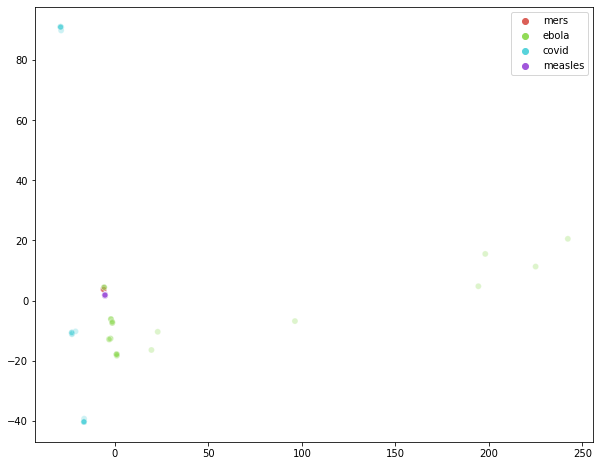

In [191]:
ys_label = [name_dict[yi] for yi in ys]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=xs_pca[:, 1],
    y=xs_pca[:, 2],
    hue=ys_label,
    palette=sns.color_palette("hls", 4),
    alpha=0.3
)

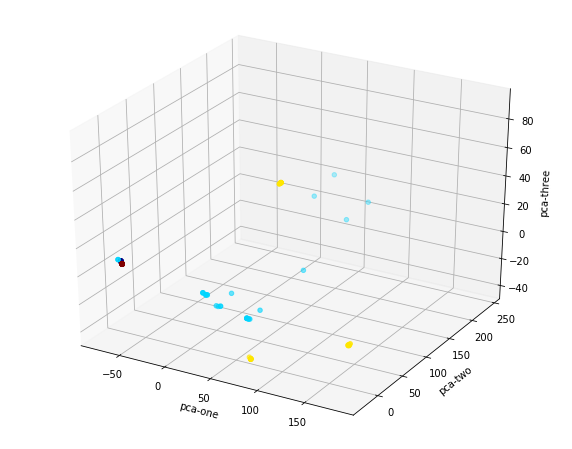

In [192]:
#plot in 3D
ax = plt.figure(figsize=(10, 8)).gca(projection='3d')
ax.scatter(
    xs=xs_pca[:,0], 
    ys=xs_pca[:,1], 
    zs=xs_pca[:,2], 
    c=ys, 
    cmap='jet'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Using t-SNE

In [187]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(xs)


[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 11.370625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.095043
[t-SNE] KL divergence after 300 iterations: 0.074648


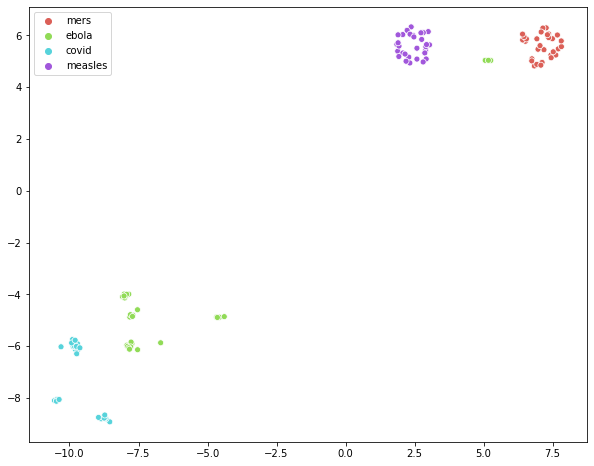

In [188]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=ys_label,
    palette=sns.color_palette("hls", 4),
#     data=xs,
    legend="full",
#     alpha=0.3
)

# Clustering

In [193]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(xs)

In [194]:
calculate_metrics(ys, y_km)

accuracy = 0.475 
precision = 0.494 
recall = 0.475 
f1 = 0.371


In [195]:
y_km[20:40]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2],
      dtype=int32)

In [196]:
y_km[40:60]

array([2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2],
      dtype=int32)

# Homework

1. How to evaluate the performance of clustering algorithm?
2. Try with variety of parameters: coding length, model parameters, use DNA directly
3. Using features rather than coding sequences
4. Problems in the recommended book: https://github.com/deepchem/DeepLearningLifeSciences